# **Sentiment Analysis on the IMDB movie reviews**

## **Context**

The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

train.tsv contains the phrases and their associated sentiment labels. We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.
test.tsv contains just phrases. You must assign a sentiment label to each phrase.
The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

## **Objective**

The dataset contains approximately 16,000 movie reviews. The objective is to do Sentiment Analysis(positive/negative) for the movie reviews using Deep Learning Sequential model Long short term Memory (LSTM) different techniques and observe the accurate results.


## **Data Dictionary**
- **Phrases:** reviews of the movies.
- **sentiment:** indicates the sentiment of the review 0 or 1( 0 is for negative review and 1 for positive review)        

## **Importing the libraries**

In [1]:
 !pip install contractions

In [2]:
!pip install nltk


In [3]:
!pip install wordcloud


In [1]:
# Importing the required the libraries

# To read and manipulate the data
import pandas as pd
pd.set_option('max_colwidth', None)

# Helps to extract the data using regular expressions
import re

# Helps to remove the punctuation
import string

# It helps to remove the accented characters

#import unidecode

# Importing the NLTK library
import nltk

nltk.download('omw-1.4')
# # downloading vader lexicon
# nltk.download('vader_lexicon')
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

# Helps to visualize the wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Used in Stemming
from nltk.stem.porter import PorterStemmer


# Used in Lemmatization
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF

# Helped to create train and test data
from sklearn.model_selection import train_test_split

# Importing the Random Forest model
from sklearn.ensemble import RandomForestClassifier

# Metrics to evaluate the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
pd.set_option('max_colwidth', None)

# To visualise the graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Helps to display the images
from PIL import Image

# Helps to visualize the wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Error loading omw-1.4: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

### **Loading the dataset**

In [3]:
# Loading data into pandas dataframe
data = pd.read_csv("sentiment analysis data.csv")

In [4]:
# Creating the copy of the data frame
df = data.copy()

In [5]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sent_count
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1,188
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2,77
2,3,1,A series,2,8
3,5,1,series,2,6
4,6,1,of escapades demonstrating the adage that what is good for the goose,2,68


In [6]:
df["SentenceId"].nunique()

8529

## **Overview of the dataset**

In [7]:
df = df.loc[:, ["Phrase", "Sentiment"]]

In [8]:
df["Sentiment"].unique()

array([1, 2, 3, 4, 0], dtype=int64)

* The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

### **Understand the shape of the dataset**

In [9]:
# Print shape of data
df.shape

(156015, 2)

### **Check the data types of the columns for the dataset**

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156015 entries, 0 to 156014
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Phrase     156015 non-null  object
 1   Sentiment  156015 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


**Observations:**

* Data has 156,015 rows and 2 columns.
* Both the columns are object type.
* There are no null values present in the dataset.

### **Checking for duplicate values**

In [11]:
# checking for duplicate values
df.duplicated().sum()

0

* There are no duplicate values present in the data .

## **Exploratory Data Analysis**

**Word Cloud for cleaned Negative Reviews**

In [12]:
# Creating word cloud for negative reviews

# Extracting the negative reviews i.e, sentiment = 0
negative_reviews = df[df['Sentiment'] == 0]

# joining the negative reviews using space seperator, helps to convert the all rows into one string
words = ' '.join(negative_reviews['Phrase'])

# helps to remove the \n characters from the previous output
cleaned_word = " ".join([word for word in words.split()])

In [13]:
# creating the wordcloud using the WordCloud() method
wordcloud = WordCloud(stopwords = STOPWORDS,
                      colormap = 'RdBu',
                      background_color = 'white',
                      width = 3000,
                      height = 2500
                     ).generate(cleaned_word) # The generate() function takes one argument of the text we created, helps to generate the wordcloud


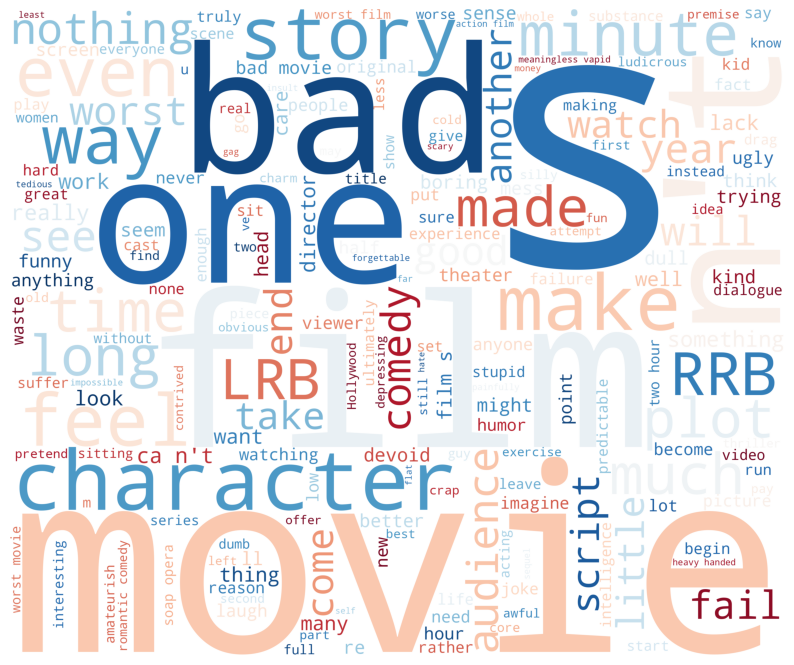

In [15]:
plt.figure(1, figsize = (10, 10))

# Using the .imshow() method of matplotlib.pyplot to display the Word Cloud as an image.
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

* The **even, bad, fail, worst, little, maybe, instead, waste, still, boring** were some of the important recurring words observed in the negative reviews.

In [16]:
# check the count of each labels
df['Sentiment'].value_counts()

2    79539
3    32927
1    27271
4     9206
0     7072
Name: Sentiment, dtype: int64

We can observe that classes are balanced.

In [17]:
new_df = df[(df["Sentiment"] == 0) | (df["Sentiment"] == 4)]

- selecting only the data that relates with the negative sentiment and the postive sentiment

In [18]:
new_df.reset_index(drop = True, inplace = True)

In [19]:
new_df.shape

(16278, 2)

### Data Preprocessing

In [20]:
def remove_special_chars(text):
  text = re.sub('[^a-zA-Z]', ' ', text)
  return text

new_df["Phrase"] = new_df["Phrase"].apply(lambda x: remove_special_chars(x))
# data.head(2)

C:\Users\User\AppData\Local\Temp\ipykernel_10872\2314774871.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["Phrase"] = new_df["Phrase"].apply(lambda x: remove_special_chars(x))


In [21]:
new_df.head(2)

,Phrase,Sentiment
0,This quiet introspective and entertaining independent is worth seeking,4
1,quiet introspective and entertaining independent,4


In [22]:
import contractions

# Let us fix the contractions in the data

def replace_contractions(text):
  return contractions.fix(text)

new_df["Phrase"] = new_df["Phrase"].apply(lambda x: replace_contractions(x))

C:\Users\User\AppData\Local\Temp\ipykernel_10872\453868620.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["Phrase"] = new_df["Phrase"].apply(lambda x: replace_contractions(x))


In [23]:
nltk.download('punkt') # for tokenization

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [24]:
new_df["Phrase"] = new_df.apply(lambda row: nltk.word_tokenize(row["Phrase"]), axis = 1)

C:\Users\User\AppData\Local\Temp\ipykernel_10872\2855419416.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["Phrase"] = new_df.apply(lambda row: nltk.word_tokenize(row["Phrase"]), axis = 1)


In [25]:
def to_lowercase(row):
  words = [word.lower() for word in row]
  return words

new_df["Phrase"] = new_df["Phrase"].apply(lambda x: to_lowercase(x))


C:\Users\User\AppData\Local\Temp\ipykernel_10872\2392620344.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["Phrase"] = new_df["Phrase"].apply(lambda x: to_lowercase(x))


In [26]:
new_df.head(2)

,Phrase,Sentiment
0,"[this, quiet, introspective, and, entertaining, independent, is, worth, seeking]",4
1,"[quiet, introspective, and, entertaining, independent]",4


In [27]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [28]:
from nltk.corpus import stopwords

stop_words = stopwords.words("english")

def remove_stopwords(row):
  words = [word for word in row if word not in stop_words]
  return words

new_df["Phrase"] = new_df["Phrase"].apply(lambda x: remove_stopwords(x))

C:\Users\User\AppData\Local\Temp\ipykernel_10872\2483735846.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["Phrase"] = new_df["Phrase"].apply(lambda x: remove_stopwords(x))


In [29]:
nltk.download("wordnet")

[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [30]:
from nltk.stem import PorterStemmer, WordNetLemmatizer

lm = WordNetLemmatizer()

ps = PorterStemmer()

def lemmatize_words(row):
  words = [lm.lemmatize(word) for word in row]
  #words = [ps.stem(word) for word in row]   # for stemming
  return words

new_df["Phrase"] = new_df["Phrase"].apply(lambda x: lemmatize_words(x))

C:\Users\User\AppData\Local\Temp\ipykernel_10872\1879169978.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["Phrase"] = new_df["Phrase"].apply(lambda x: lemmatize_words(x))


### Putting All together

In [31]:
def join_words(row):
  words = " ".join([word for word in row])
  return words

new_df["Phrase"] = new_df["Phrase"].apply(lambda x: join_words(x))

C:\Users\User\AppData\Local\Temp\ipykernel_10872\589985422.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["Phrase"] = new_df["Phrase"].apply(lambda x: join_words(x))


In [32]:
new_df.head(3)

,Phrase,Sentiment
0,quiet introspective entertaining independent worth seeking,4
1,quiet introspective entertaining independent,4
2,entertaining,4


In [33]:
#new_df.to_csv("/content/drive/MyDrive/Files/Data/cleaned_df.csv", index = False)

## **Sequential model - LSTM**

Sequential models is a common name for Neural Network architectures, that have units with memory. Here we shall be using LSTM, which is a type of Recurrent Neural Network layer as the memory units.

A typical LSTM unit is made up of a cell, an input gate, an output gate, and a forget gate. The cell is responsible for "remembering" values over extended periods of time and "forgetting" certain values when the context changes. This allows LSTM to maintain "memory." Each of the three gates can be viewed as a Fully-Connected Artificial Neural Network, or Multi-Layer Perceptrons. They calculate an activation (using an activation function) of a weighted sum. Additionally, the input and output vectors are accompanied by a context vector that contains information about the summary of the text it has processed thus far.

Intuitively, the gates regulate the flow of values that pass through the connections of the LSTM, which is why they are referred to as "gates." They tend to output values between '1' and '0', where '1' is multiplied with the context and input vectors. The values that are multiplied with zero are forgotten and those multiplied with 1 are remembered.

**Components of the LSTM**

The LSTM cell contains the following components:

- Forget Gate “f” ( a neural network with sigmoid)
- Candidate layer “C"(a NN with Tanh)
- Input Gate “I” ( a NN with sigmoid )
- Output Gate “O”( a NN with sigmoid)
- Hidden state “H” ( a vector )
- Memory state “C” ( a vector)

Inputs to the LSTM cell at any step are Xt (current input) , Ht-1 (previous hidden state ) and Ct-1 (previous memory state).

Outputs from the LSTM cell are Ht (current hidden state ) and Ct (current memory state)



**Working of gates in LSTM**

First, LSTM cell takes the previous memory state Ct-1 and does element wise multiplication with forget gate (f) to decide if present memory state Ct. If forget gate value is 0 then previous memory state is completely forgotten else f forget gate value is 1 then previous memory state is completely passed to the cell ( Remember f gate gives values between 0 and 1 ).

Ct = Ct-1 * ft

Calculating the new memory state:

Ct = Ct + (It * C`t)

Now, we calculate the output:

Ht = tanh(Ct)

In [34]:
# Helped to create train and test data
from sklearn.model_selection import train_test_split

# Metrics to evaluate the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Used to create the Sequential model
from tensorflow.keras.models import Sequential
#import tensorflow as tf
# Used to create the tokens from the text data
from tensorflow.keras.preprocessing.text import Tokenizer

# Helps to pad the sequences into the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Layers that are used to implement the LSTM model
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### **Tokenizing and converting the reviews into numerical vectors**

In [35]:
# Creating the tokenizer with 700 vocab size
# using only 700 vocabularies (unique words) in the dataset
tokenizer = Tokenizer(num_words = 700, split = ' ')

tokenizer.fit_on_texts(new_df['Phrase'].values)

# converting text to sequences
X = tokenizer.texts_to_sequences(new_df['Phrase'].values)
# tokenizing the sentences and converting it to sequences of integars
# the integars are positions that represent the index of each word in the original text - not one-encoded values
# Padding the sequences
X = pad_sequences(X, 100)
# 100 represents maximum length for character limit

- note that if the goal is to build an app such that users will put their input from the frontend, and then pre-processed by the machine learning engineer (you), the tokenizer responsible for converting the input to sequences must be saved

In [36]:
# saving the tokenizer
import pickle

with open("tokenizer.pkl", "wb") as handle:
  pickle.dump(tokenizer, handle)

**Model Building**

In [37]:
model = Sequential()

# model will take as input an integer matrix of size (batch, input_length), and the largest integer (i.e. word index) in the input
# should be no larger than vocabulary size. Now model.output_shape is (None, input_length, 256), where `None` is the batch dimension.
# input_length is X_data[1] = 700 here.
model.add(Embedding(700, 120, input_length = 100))

model.add(SpatialDropout1D(0.2))

 # return_sequences = True means each LSTM cell in it is outputting its value.The output of the layer is a sequence of outputs.
model.add(LSTM(150, dropout = 0.2, recurrent_dropout = 0.2))

model.add(Dense(2, activation = 'sigmoid'))

# compile the model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [38]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 120)          84000     
                                                                 
 spatial_dropout1d (Spatial  (None, 100, 120)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 150)               162600    
                                                                 
 dense (Dense)               (None, 2)                 302       
                                                                 
Total params: 246902 (964.46 KB)
Trainable params: 246902 (964.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


A sequential model is constructed by adding various layers to it.

- The first layer is the Embedding layer which transforms one-hot encoded sparse vectors into Word Embedding vectors. As the model continues to train, the weights of the Embedding layer are adjusted so that words with similar meanings are located closer together in the vector space, or have similar Word Embedding Vectors. For example, "orange" would be located near "tangerine" and "queen" would be near "empress." The vocabulary size is specified.

- The subsequent layer is an LSTM layer with 150 neurons. The input for this layer is a list of sentences, where each word has been converted to its corresponding Embedding vector and padded to have the same length. The activation function used is ReLU, which is widely used, but other relevant activation functions can also be used.

- To prevent bias, a dropout layer is employed to regulate the network.

- The final layer is a Dense layer which serves as the output layer and has 2 cells to perform classification, representing the 2 different categories in this example.

- The model is then compiled using the Adam optimizer and categorical cross-entropy. The Adam optimizer is currently the best choice for handling sparse gradients and noisy problems, and categorical cross-entropy is typically used when the classes are mutually exclusive, meaning each sample belongs to exactly one class.

**Splitting the Data**

In [39]:
new_df["Sentiment"].replace(4, 1, inplace = True)
# because we are only using two classes; 4 representing positive

C:\Users\User\AppData\Local\Temp\ipykernel_10872\3697521266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["Sentiment"].replace(4, 1, inplace = True)


In [40]:
# creating the target feature
y = new_df["Sentiment"]

# Splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [41]:
from tensorflow.keras.utils import to_categorical

In [42]:
y_train_enc = to_categorical(y_train, 2)
y_test_enc = to_categorical(y_test, 2)

**Training the model**

In [43]:
model_path = "nlp_model.h5"
es = EarlyStopping(patience=3, verbose=2, monitor = "val_loss")
chkpt = ModelCheckpoint(model_path, verbose = 2, save_best_only = True)

In [44]:
y_train_enc

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [45]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()


In [46]:
# specifying the batch size
batch_size = 32

# fitting the model on the training data with 10 epochs
his = model.fit(X_train, y_train_enc, epochs = 10, batch_size = batch_size, callbacks=[es, chkpt],verbose = 1,
                validation_split = 0.1)

Epoch 1/10


413/413 [==============================] - ETA: 0s - loss: 0.4483 - accuracy: 0.7780
Epoch 1: val_loss improved from inf to 0.31043, saving model to nlp_model.h5
413/413 [==============================] - 142s 321ms/step - loss: 0.4483 - accuracy: 0.7780 - val_loss: 0.3104 - val_accuracy: 0.8614
Epoch 2/10


C:\Users\User\anaconda3\envs\mlopz\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


413/413 [==============================] - ETA: 0s - loss: 0.3058 - accuracy: 0.8579
Epoch 2: val_loss improved from 0.31043 to 0.29605, saving model to nlp_model.h5
413/413 [==============================] - 122s 296ms/step - loss: 0.3058 - accuracy: 0.8579 - val_loss: 0.2960 - val_accuracy: 0.8676
Epoch 3/10
413/413 [==============================] - ETA: 0s - loss: 0.2894 - accuracy: 0.8662
Epoch 3: val_loss improved from 0.29605 to 0.29230, saving model to nlp_model.h5
413/413 [==============================] - 122s 295ms/step - loss: 0.2894 - accuracy: 0.8662 - val_loss: 0.2923 - val_accuracy: 0.8683
Epoch 4/10
413/413 [==============================] - ETA: 0s - loss: 0.2743 - accuracy: 0.8714
Epoch 4: val_loss improved from 0.29230 to 0.28417, saving model to nlp_model.h5
413/413 [==============================] - 124s 299ms/step - loss: 0.2743 - accuracy: 0.8714 - val_loss: 0.2842 - val_accuracy: 0.8676
Epoch 5/10
413/413 [==============================] - ETA: 0s - loss: 0.257